#### Import statments


In [42]:
import operator
from typing import Annotated, Literal, TypedDict

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import END, START, StateGraph

# Mermaid drawing method (prefer langchain_core enum)
try:
    from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
except Exception:
    MermaidDrawMethod = None

import nest_asyncio

nest_asyncio.apply()

AWS_REGION = "eu-west-2"
AWS_PROFILE = "sandbox"

### Define Tool and Models


#### Create Model


In [43]:
nova_micro = init_chat_model(
    model="amazon.nova-micro-v1:0",
    temperature=0,
    max_tokens=4048,
    model_provider="bedrock_converse",
    region_name=AWS_REGION,
    credentials_profile_name=AWS_PROFILE,
)


#### Create some tools


In [44]:
@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers"""
    return a * b


@tool
def add(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b


@tool
def divide(a: float, b: float) -> float:
    """Divide two numbers"""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b


all_tools = [multiply, add, divide]
tool_by_name = {tool.name: tool for tool in all_tools}

#### Bind tools with model


In [45]:
model_with_tools = nova_micro.bind_tools(all_tools)

### Create State

The graph state is used to store the messages and the number of LLM calls


In [51]:
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

#### Define Model node


In [53]:
def llm_call(state: dict):
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1,
    }

#### Define Tool Node


In [54]:
def tool_node(state: dict):
    results = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tool_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        results.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": results}

#### Define end logic

The conditional edge function is used to route to the tool node of end bassed upon whether the LLM made a tool call.


In [55]:
def should_continue(state: MessageState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLm made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tool_node"

    return END

### Build and compilee the agent

In [64]:
agent_builder= StateGraph(MessageState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START,"llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node",END]
)

agent_builder.add_edge("tool_node", "llm_call")

agent=agent_builder.compile()
# print(agent.get_graph(xray=True))




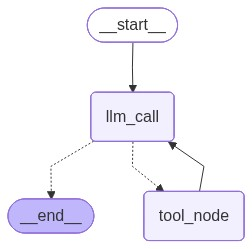

In [ ]:
import base64
import requests

mermaid_code = agent.get_graph().draw_mermaid()

graphbytes = mermaid_code.encode("utf8")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")

url = f"https://mermaid.ink/img/{base64_string}"
response = requests.get(url)
if response.status_code == 200:
    display(Image(response.content))
else:
    print(f"Error: Status code {response.status_code}")
    print("Try copying the code to https://mermaid.live instead")

display(Image(agent.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [68]:
# agent.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)

In [69]:
messages=[HumanMessage(content="Add 3 and 4.")]
messages= agent.invoke({"messages":messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> The User wants to add two numbers: 3 and 4. The "add" tool is suitable for this task. I will use this tool to perform the addition.</thinking>\n'}, {'type': 'tool_use', 'name': 'add', 'input': {'a': 3, 'b': 4}, 'id': 'tooluse_C-kvPudjSGGI6_UzfcpiwQ'}]
Tool Calls:
  add (tooluse_C-kvPudjSGGI6_UzfcpiwQ)
 Call ID: tooluse_C-kvPudjSGGI6_UzfcpiwQ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7.0
================================== Ai Message ==================================

The sum of 3 and 4 is 7.0. If you need any further calculations, just let me know!
